In [1]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
import numpy as np
import os

# Directory containing CIFAR-10 batches
data_dir = 'D:\\CSE 440\\cifar-10-batches-py'

# Load all data batches
def load_cifar10_data(data_dir):
    # Initialize empty lists for images and labels
    images = []
    labels = []
    
    # Load each data batch
    for batch_id in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f'data_batch_{batch_id}'))
        images.append(batch[b'data'])
        labels += batch[b'labels']
    
    # Stack the image arrays and reshape to (50000, 32, 32, 3)
    images = np.vstack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(labels)
    
    # Load the test batch
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    test_images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch[b'labels'])
    
    return images, labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_cifar10_data(data_dir)
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import matplotlib.pyplot as plt
import os
import pickle

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_images_split, val_images, train_labels_split, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

train_dataset = CIFAR10CustomDataset(train_images_split, train_labels_split, transform=transform)
val_dataset = CIFAR10CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CIFAR10CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super(NeuralNet, self).__init__()
        self.model = timm.create_model("mobilenetv3_large_100", pretrained=True, num_classes=num_classes)    
        
    def forward(self, x):
        return self.model(x)

class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = [NeuralNet().to(device) for _ in range(population_size)]
    
    def train_model(self, model, train_loader, criterion, optimizer, scheduler, epochs):
        model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            correct = 0
            total = 0
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
    
                # Zero the parameter gradients
                optimizer.zero_grad()
    
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                # Accumulate loss
                running_loss += loss.item()
    
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
            train_acc = 100 * correct / total
    
            # Calculate average loss for the epoch
            avg_loss = running_loss / len(train_loader)
            
            # Scheduler step with the validation metric
            scheduler.step(avg_loss)  # Use the average training loss as the metric
    
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        return train_acc


    def evaluate_model(self, model, val_loader):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        return val_acc

    def mutate(self, model):
        # Mutate the model weights with some noise
        with torch.no_grad():
            for param in model.parameters():
                if torch.rand(1).item() < self.mutation_rate:
                    noise = torch.randn_like(param) * 0.05  # Adjust noise scale as needed
                    param.add_(noise)

    def run_evolution(self):
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        best_model = None

        for generation in range(self.generations):
            print(f"Generation {generation + 1}/{self.generations}")

            accuracies = []
            for idx, model in enumerate(self.population):
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
                
                train_acc = self.train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5)
                val_acc = self.evaluate_model(model, val_loader)
                accuracies.append(val_acc)
                print(f"Model {idx + 1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

                # Check if this is the best model so far
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_model = model

            # Reproduction: Select two best models to reproduce
            sorted_indices = np.argsort(accuracies)[-2:]
            parent1, parent2 = self.population[sorted_indices[0]], self.population[sorted_indices[1]]

            # Generate new population through crossover and mutation
            new_population = []
            for _ in range(self.population_size):
                child = NeuralNet().to(device)
                child.load_state_dict(parent1.state_dict(), strict=False)
                self.mutate(child)
                new_population.append(child)

            self.population = new_population

        # Evaluate the best model on the test set
        test_accuracy = self.evaluate_model(best_model, test_loader)
        print(f"Test Accuracy of the best model: {test_accuracy:.2f}%")
        
        # Return the best model for later use
        return best_model

# Run Genetic Algorithm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GA = GeneticAlgorithm(population_size=8, mutation_rate=0.05, generations=4)
best_model = GA.run_evolution()

Generation 1/4


C:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5], Loss: 0.5394, Train Acc: 83.35%
Epoch [2/5], Loss: 0.2802, Train Acc: 90.84%
Epoch [3/5], Loss: 0.2288, Train Acc: 92.54%
Epoch [4/5], Loss: 0.1902, Train Acc: 93.66%
Epoch [5/5], Loss: 0.0669, Train Acc: 97.72%
Model 1: Train Acc = 97.72%, Val Acc = 93.23%
Epoch [1/5], Loss: 0.5344, Train Acc: 83.56%
Epoch [2/5], Loss: 0.2771, Train Acc: 90.92%
Epoch [3/5], Loss: 0.2243, Train Acc: 92.66%
Epoch [4/5], Loss: 0.1968, Train Acc: 93.56%
Epoch [5/5], Loss: 0.0621, Train Acc: 97.89%
Model 2: Train Acc = 97.89%, Val Acc = 93.70%
Epoch [1/5], Loss: 0.5277, Train Acc: 83.98%
Epoch [2/5], Loss: 0.2838, Train Acc: 90.61%
Epoch [3/5], Loss: 0.2278, Train Acc: 92.56%
Epoch [4/5], Loss: 0.1888, Train Acc: 93.78%
Epoch [5/5], Loss: 0.0617, Train Acc: 97.84%
Model 3: Train Acc = 97.84%, Val Acc = 93.26%
Epoch [1/5], Loss: 0.5304, Train Acc: 83.50%
Epoch [2/5], Loss: 0.2736, Train Acc: 91.08%
Epoch [3/5], Loss: 0.2258, Train Acc: 92.67%
Epoch [4/5], Loss: 0.1892, Train Acc: 93.75%
Epoch [

<h1>GA with Adam</h1>

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
criterion = nn.CrossEntropyLoss()

def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

# Testing the model
test_loss, true_labels, predictions = test_model(best_model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)


Test Loss: 0.2427
Classification Report:
              precision    recall  f1-score   support

    airplane     0.9259    0.9750    0.9498      1000
  automobile     0.9442    0.9810    0.9622      1000
        bird     0.9266    0.9210    0.9238      1000
         cat     0.8697    0.9080    0.8885      1000
        deer     0.9363    0.9550    0.9455      1000
         dog     0.9509    0.8530    0.8993      1000
        frog     0.9545    0.9660    0.9602      1000
       horse     0.9629    0.9590    0.9609      1000
        ship     0.9697    0.9600    0.9648      1000
       truck     0.9791    0.9350    0.9565      1000

    accuracy                         0.9413     10000
   macro avg     0.9420    0.9413    0.9412     10000
weighted avg     0.9420    0.9413    0.9412     10000

Confusion Matrix:
[[975   2   5   1   1   0   0   2  12   2]
 [  5 981   1   0   0   0   0   0   3  10]
 [ 19   0 921  13  16   4  17   7   3   0]
 [  9   2  17 908  10  30  12   5   6   1]
 [  4   1 

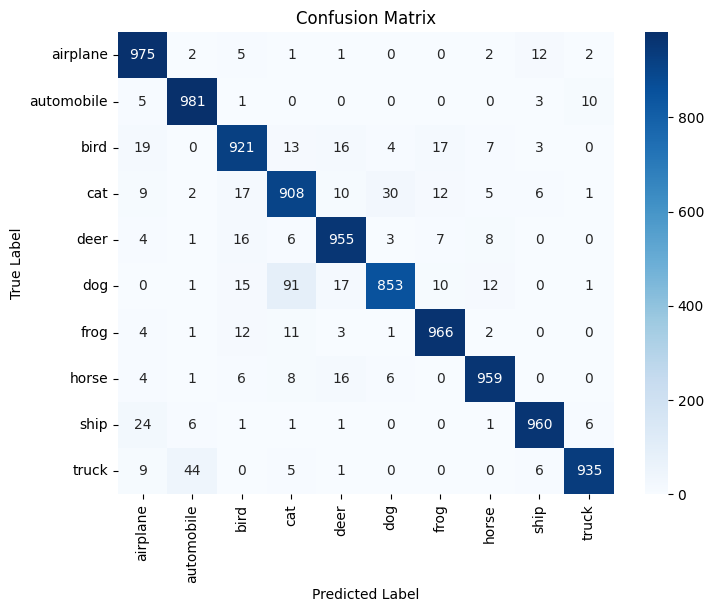

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

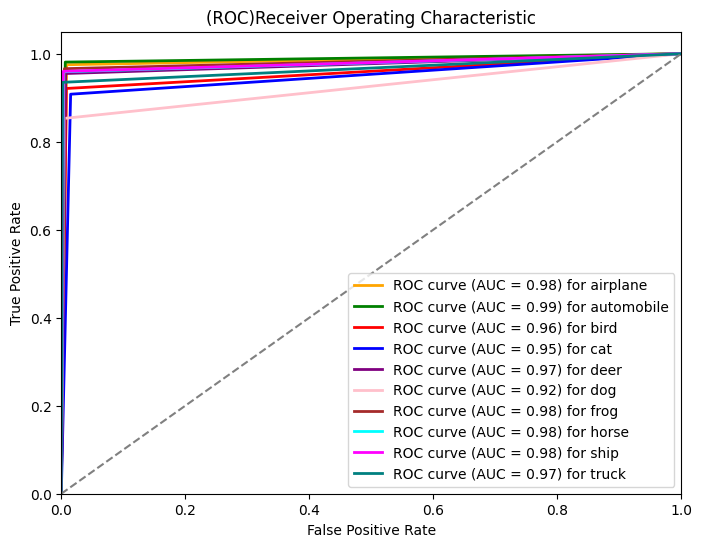

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink', 'brown', 'cyan', 'magenta', 'teal']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

<h1>Training without GA</h1> 

In [11]:
import torch.nn as nn
import torch.optim as optim
import timm

num_classes = 10  

model = timm.create_model("mobilenetv3_large_100", pretrained=True, num_classes=num_classes)    
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
from torchinfo import summary
summary(model = model, 
        input_size=(10, 3, 224, 224),  
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
MobileNetV3 (MobileNetV3)                          [10, 3, 224, 224] [10, 10]        --              True
├─Conv2d (conv_stem)                               [10, 3, 224, 224] [10, 16, 112, 112] 432             True
├─BatchNormAct2d (bn1)                             [10, 16, 112, 112] [10, 16, 112, 112] 32              True
│    └─Identity (drop)                             [10, 16, 112, 112] [10, 16, 112, 112] --              --
│    └─Hardswish (act)                             [10, 16, 112, 112] [10, 16, 112, 112] --              --
├─Sequential (blocks)                              [10, 16, 112, 112] [10, 960, 7, 7] --              True
│    └─Sequential (0)                              [10, 16, 112, 112] [10, 16, 112, 112] --              True
│    │    └─DepthwiseSeparableConv (0)             [10, 16, 112, 112] [10, 16, 112, 112] 464             True
│    └─Sequential (1)  

In [13]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_max = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        '''Saves model when validation accuracy increases.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_accuracy_max:.6f} --> {val_accuracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_max = val_accuracy

In [14]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar3.pt')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True, factor=0.1)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device).long()
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device).long()
                outputs = model(data)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)

        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        scheduler.step(val_loss)

        early_stopping(val_accuracy, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar3.pt'))

    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=100,
    device=device,
    patience=10  
)

C:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Accuracy: 0.5348, Train Loss: 1.4425, Validation Loss: 1.1591, Validation Accuracy: 0.6183
Validation accuracy increased (inf --> 0.618300).  Saving model ...
Epoch 2/100, Train Accuracy: 0.6924, Train Loss: 0.8964, Validation Loss: 0.9137, Validation Accuracy: 0.6853
Validation accuracy increased (0.618300 --> 0.685300).  Saving model ...
Epoch 3/100, Train Accuracy: 0.7453, Train Loss: 0.7509, Validation Loss: 0.7660, Validation Accuracy: 0.7419
Validation accuracy increased (0.685300 --> 0.741900).  Saving model ...
Epoch 4/100, Train Accuracy: 0.7764, Train Loss: 0.6575, Validation Loss: 0.6867, Validation Accuracy: 0.7677
Validation accuracy increased (0.741900 --> 0.767700).  Saving model ...
Epoch 5/100, Train Accuracy: 0.8016, Train Loss: 0.5847, Validation Loss: 0.5487, Validation Accuracy: 0.8167
Validation accuracy increased (0.767700 --> 0.816700).  Saving model ...
Epoch 6/100, Train Accuracy: 0.8243, Train Loss: 0.5278, Validation Loss: 0.5829, Validati

C:\Users\User\AppData\Local\Temp\ipykernel_24700\133463087.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Checkp

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

test_loss, true_labels, predictions = test_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)

Test Loss: 0.5111
Classification Report:
              precision    recall  f1-score   support

    airplane     0.8787    0.9130    0.8955      1000
  automobile     0.9432    0.9640    0.9535      1000
        bird     0.8738    0.8380    0.8555      1000
         cat     0.8057    0.7960    0.8008      1000
        deer     0.8683    0.8970    0.8824      1000
         dog     0.8416    0.8500    0.8458      1000
        frog     0.9152    0.9170    0.9161      1000
       horse     0.9463    0.9170    0.9314      1000
        ship     0.9378    0.9340    0.9359      1000
       truck     0.9511    0.9340    0.9425      1000

    accuracy                         0.8960     10000
   macro avg     0.8962    0.8960    0.8959     10000
weighted avg     0.8962    0.8960    0.8959     10000

Confusion Matrix:
[[913   7  19  11   7   1   3   2  28   9]
 [  9 964   0   1   0   1   0   0   1  24]
 [ 36   1 838  31  27  26  30   4   6   1]
 [ 12   2  26 796  32  88  29  10   5   0]
 [ 10   2 

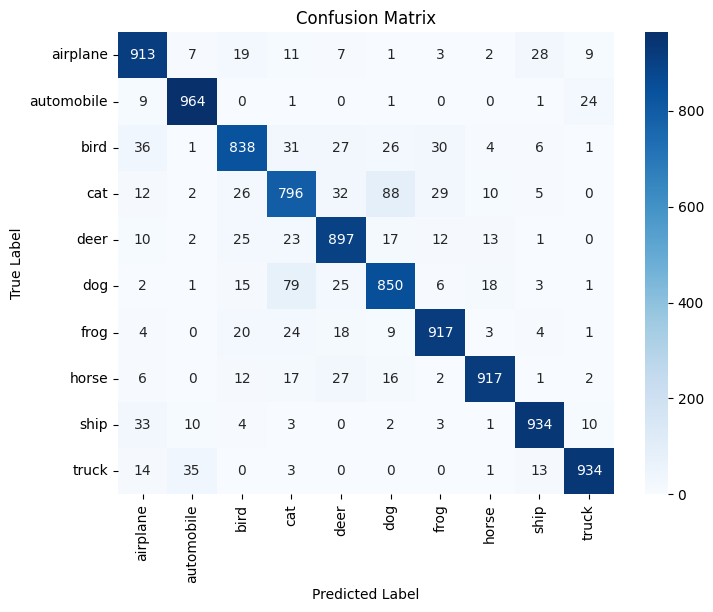

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

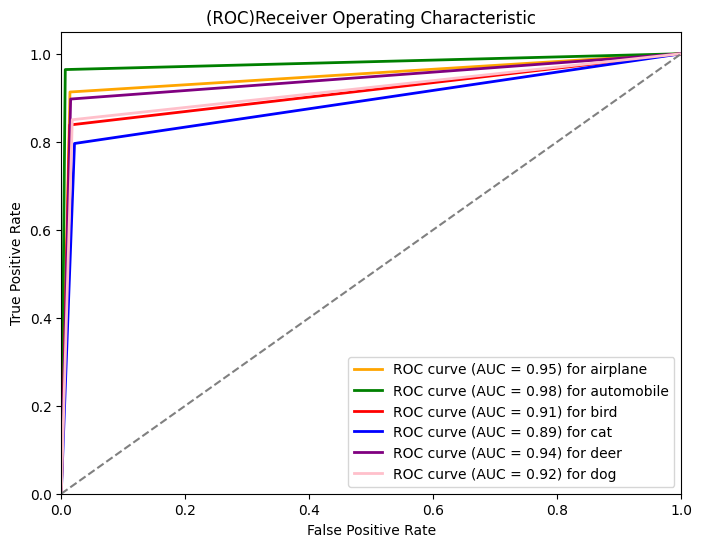

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink', 'brown', 'cyan', 'magenta', 'teal']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()